In [19]:
import numpy as np
import os
import sys       
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

# Get the path of the parent_directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
bin_dir = parent_dir + "/data/raw/bin_files"
csv_dir = parent_dir + "/data/raw/excel_files"
sys.path.append(parent_dir)

# For .bin patch parsing
from patch.Processing.processECG import process_ECG
from patch.Processing.processPPG import process_PPG, select_ppg_array, extract_PPG_fiducial
from patch.Processing.processSCG import process_SCG, extract_SCG_fiducials
from patch.Tools.preprocessing import get_filt_dict, dict_interpolation
from patch.Tools.pipelineConfig import *
from patch.Tools.patchParser import get_newest_patch_file, parse_file

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
bin_file_paths = os.listdir(bin_dir)
bin_file_paths = [bin_dir + '/' + s for s in bin_file_paths]

In [21]:
print(bin_file_paths[15])
raw_dict = parse_file(bin_file_paths[15])

/home/michael/Code/mims-transformer-stress-classification/data/raw/bin_files/3160.bin


Device name: HP-0247
Last sync time: Tue Jul 26 12:54:07 2022 UTC
Accel Size: 21373746
PPG Size: 1403289
ECG Size: 10548184
Environmental Size: 42746
AST Time Length: 21109.423828125
204962736 100.0% done                      

STATS:
Measurement Length: 21109.34 seconds
File Size: 204963.328 kbytes
Average data rate: 9709.6 bytes/second
Theoretical uncompressed data rate: 17370.71 bytes/second
PPG is 12.32% of the data
ECG is 12.36% of the data
Accel is 50.18% of the data
Environmental is 0.15% of the data
AST is 10.46% of the data
Data Flag is 10.43% of the data
time ellapsed: 41.422 seconds
parse speed: 4948194.991 bytes/second
parse speed: 509.619 dataSeconds/second


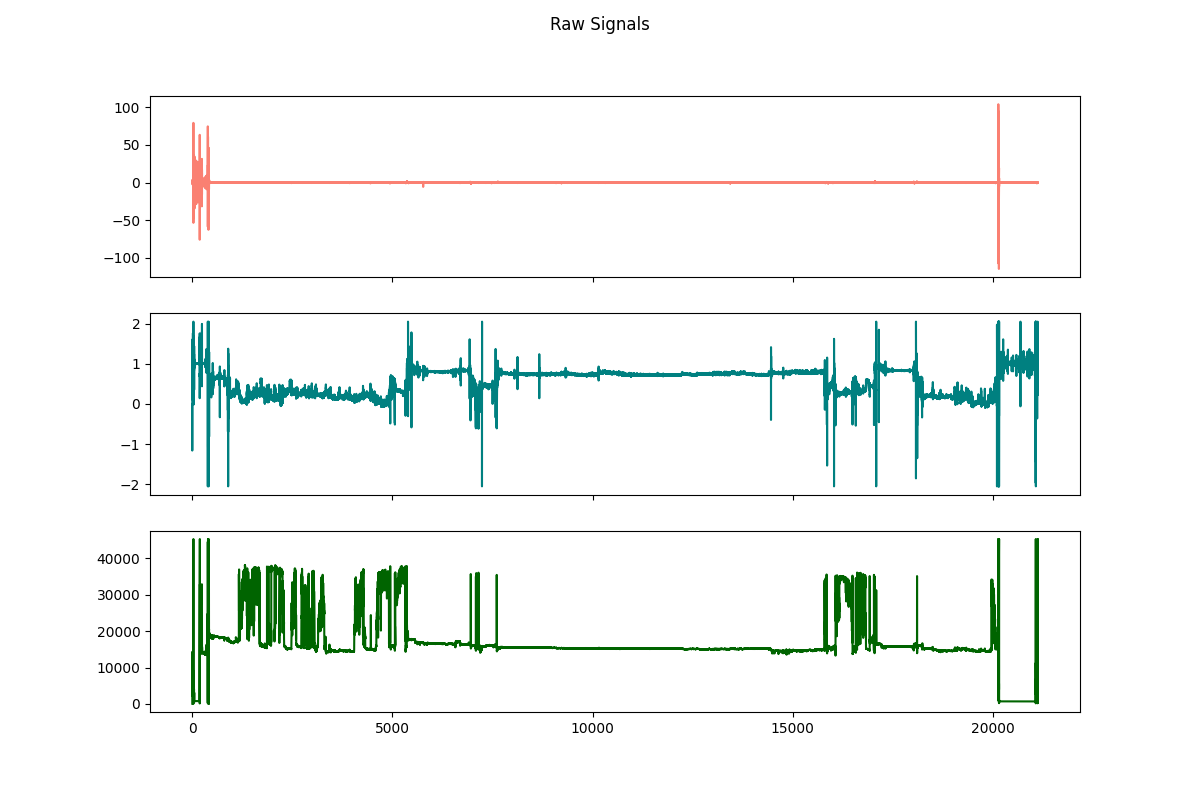

In [22]:
#%matplotlib inline
fig, axs = plt.subplots(3,1, sharex=True, figsize=(12,8))
plt.suptitle("Raw Signals")
axs[0].plot(raw_dict['ecg_time'], raw_dict['ecg'], color='salmon')
axs[1].plot(raw_dict['accel_time'], raw_dict['accel_z'], color='teal')
axs[2].plot(raw_dict['ppg_time'], raw_dict['ppg_ir_2'], color='darkgreen')
plt.show()

## Resample to uniformity

In [23]:
patch_dict = dict_interpolation(raw_dict, fs_resample=FS_RESAMPLE)
print(patch_dict.keys())

dict_keys(['ecg', 'scg_LT', 'scg_HF', 'scg_DV', 'ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2', 'ppg_ir_2', 'temp_skin', 'time'])


In [24]:
patch_filt_dict = get_filt_dict(patch_dict, FILT_ECG, FILT_SCG, FILT_PPG, Fs=FS_RESAMPLE)

(-1000.0, 1000.0)

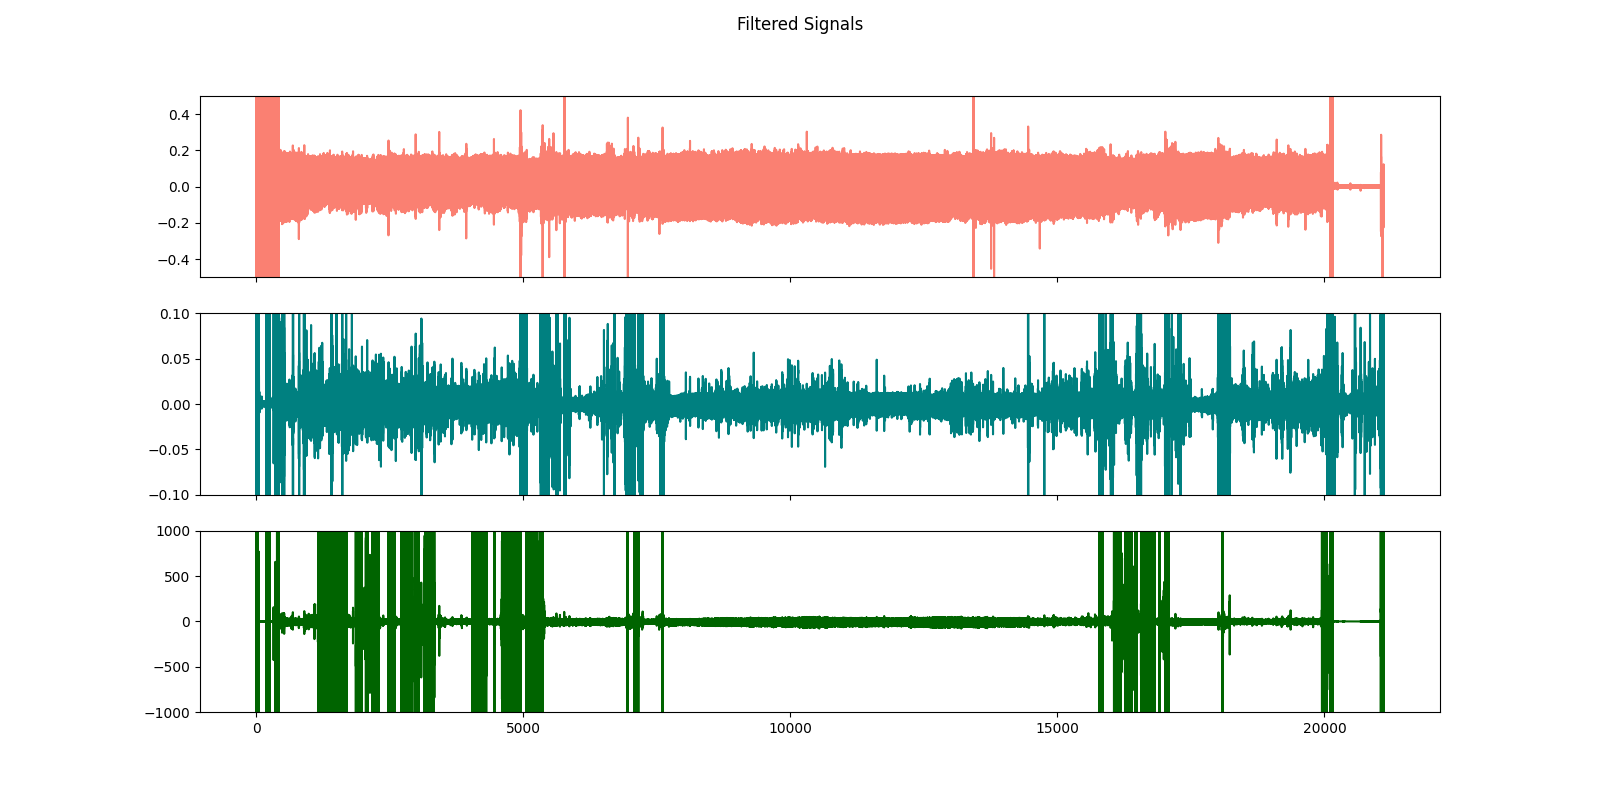

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(3,1, sharex=True, figsize=(16,8))
plt.suptitle("Filtered Signals")
axs[0].plot(patch_filt_dict['time'], patch_filt_dict['ecg'], color='salmon'); axs[0].set_ylim([-0.5, 0.5])
axs[1].plot(patch_filt_dict['time'], patch_filt_dict['scg_DV'], color='teal'); axs[1].set_ylim([-0.1, 0.1])
axs[2].plot(patch_filt_dict['time'], patch_filt_dict['ppg_g_2'], color='darkgreen'); axs[2].set_ylim([-1000, 1000])


In [28]:
df_timestamps = pd.read_csv(csv_dir + '/sub3160/df_timestamps.csv')

In [29]:
df_timestamps['timestamp'] = df_timestamps['timestamp'] - df_timestamps['timestamp'][0]
print(df_timestamps)

    Unnamed: 0                    ts_name             datetime  timestamp
0            0         patch_placed_start  2022-07-26 09:01:00        0.0
1            0               rest_1_start  2022-07-26 11:04:00     7380.0
2            0                 rest_1_end  2022-07-26 11:26:22     8722.0
3            0               rest_2_start  2022-07-26 11:44:09     9789.0
4            0                 rest_2_end  2022-07-26 12:09:49    11329.0
5            0               script_start  2022-07-26 12:24:52    12232.0
6            0            prep_2min_start  2022-07-26 12:28:44    12464.0
7            0        speaking_3min_start  2022-07-26 12:30:52    12592.0
8            0          speaking_3min_end  2022-07-26 12:33:51    12771.0
9            0       recovery_20min_start  2022-07-26 12:33:55    12775.0
10           0  recovery_20min_poststress  2022-07-26 12:58:30    14250.0


In [33]:
# Indicies for start and stop times (index loc) of activities
rest_2_start = next(x for x, val in enumerate(patch_filt_dict['time']) if val > df_timestamps['timestamp'][3])
rest_2_end = next(x for x, val in enumerate(patch_filt_dict['time']) if val > df_timestamps['timestamp'][4])
script_start = next(x for x, val in enumerate(patch_filt_dict['time']) if val > df_timestamps['timestamp'][5])
script_end = next(x for x, val in enumerate(patch_filt_dict['time']) if val > df_timestamps['timestamp'][5] + 120)
prep_start = next(x for x, val in enumerate(patch_filt_dict['time']) if val > df_timestamps['timestamp'][6])
prep_end = next(x for x, val in enumerate(patch_filt_dict['time']) if val > df_timestamps['timestamp'][6] + 120)
speaking_start = next(x for x, val in enumerate(patch_filt_dict['time']) if val > df_timestamps['timestamp'][7])
speaking_end = next(x for x, val in enumerate(patch_filt_dict['time']) if val > df_timestamps['timestamp'][8])
recovery_start = next(x for x, val in enumerate(patch_filt_dict['time']) if val > df_timestamps['timestamp'][9])
recovery_end = next(x for x, val in enumerate(patch_filt_dict['time']) if val > df_timestamps['timestamp'][9] + 1200)


In [46]:
rest_2 = {key: patch_filt_dict[key][rest_2_start:rest_2_end] for key in patch_filt_dict.keys()}
script = {key: patch_filt_dict[key][script_start:script_end] for key in patch_filt_dict.keys()}
prep = {key: patch_filt_dict[key][prep_start:prep_end] for key in patch_filt_dict.keys()}
speaking = {key: patch_filt_dict[key][speaking_start:speaking_end] for key in patch_filt_dict.keys()}
recovery = {key: patch_filt_dict[key][recovery_start:recovery_end] for key in patch_filt_dict.keys()}

ECG signal was inverted.
Number of peaks found:
   Neurokit (1724)
   Martinez (1706)
   Kalidas (1725)
   Common (1724)
1719 NN intervals detected from 1724 peaks.


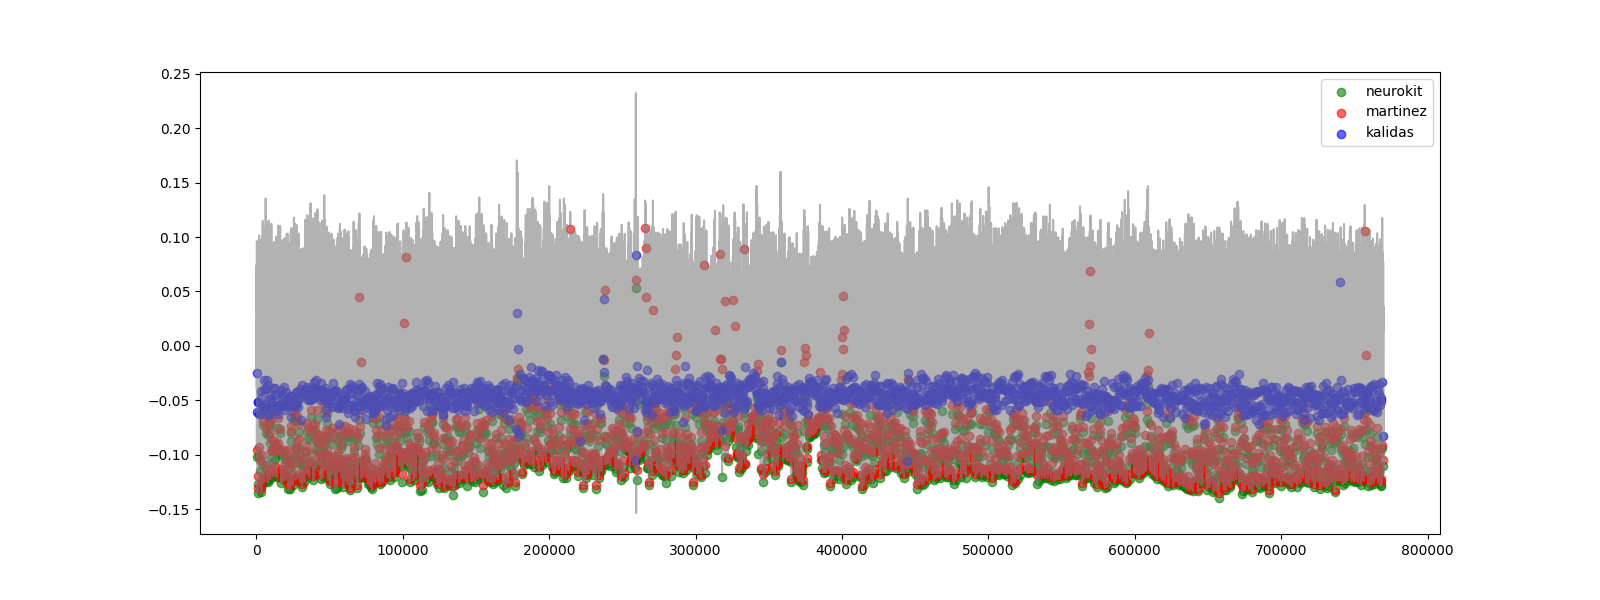

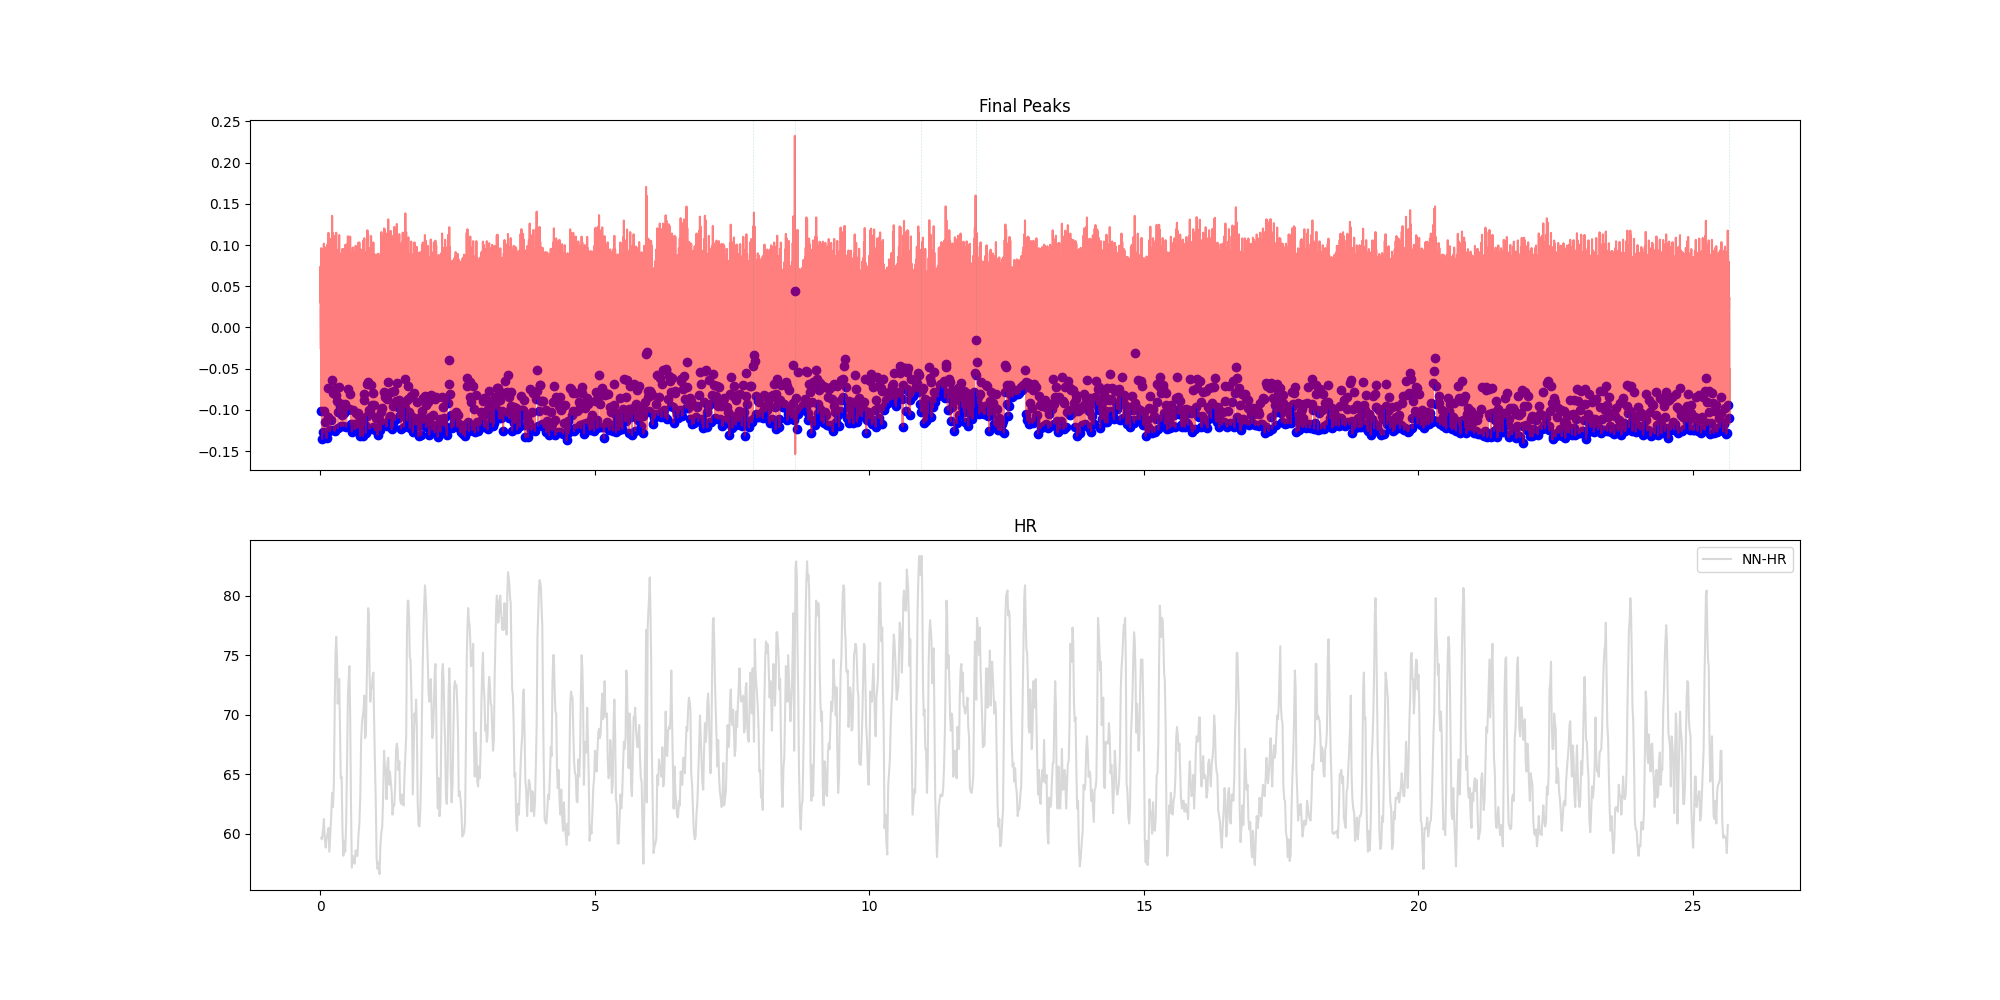

In [47]:
# Note we pass the raw ECG here, as we use different R-peak detectors that each require specific filtering
ecg_dict = process_ECG(rest_2['ecg'],
                        rest_2['time'],
                        force_inverse=False,
                        width_QRS=width_QRS,
                        peak_tol=pk_tolerance_ms, 
                        beat_len=beat_length, 
                        Fs=FS_RESAMPLE, 
                        verbose=True, 
                        plotFlag=True)

Using PPG array 2
Begin processing PPG
Stage 1: Global MAD removed 327 out of 1719
Stage 2: Moving window MAD removed 52 out of 1392
Stage 3: Moving window DTW removed 1 out of 1340
Stage 4: Global DTW fusion removed 2 out of 1340
Final: Using 1339 beats out of 1719


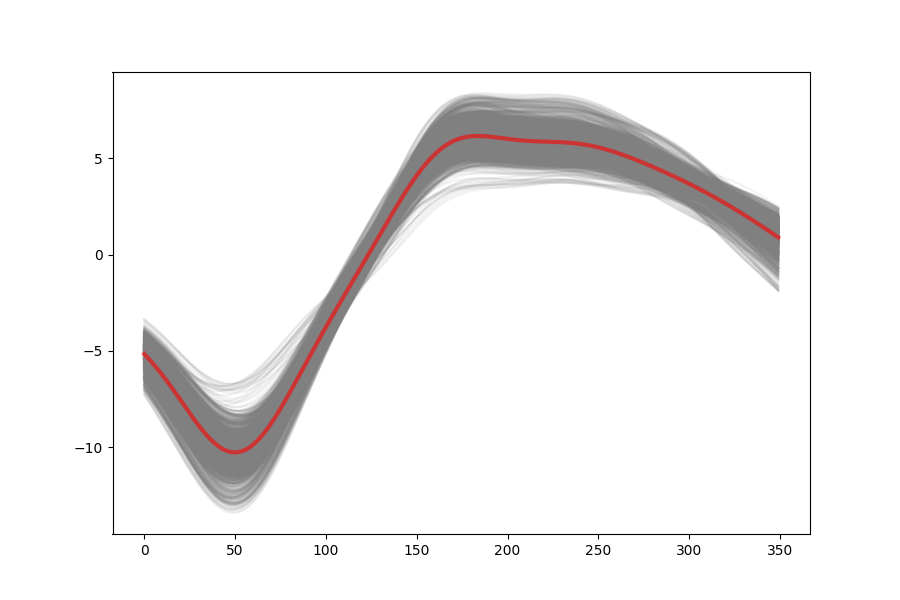

In [48]:
# PPG Array selection
ppg_arr,_ = select_ppg_array(rest_2[ppg_wavelen+'_1'], 
                            rest_2[ppg_wavelen+'_2'], 
                            verbose=True)

# Process PPG
ppg_dict = process_PPG(rest_2[ppg_wavelen+ppg_arr], 
                        rest_2[ppg_wavelen+ppg_arr], 
                        ecg_dict, 
                        ensembleSize=ensemble_length, 
                        useTemplateSQI=True,
                        beat_len=beat_length, 
                        Fs=FS_RESAMPLE, 
                        verbose=True)

plt.figure(figsize=(9, 6))
_=plt.plot(ppg_dict['ppg_beats'], color='gray', alpha=0.1)
_=plt.plot(np.mean(ppg_dict['ppg_beats'], axis=1), color='red', alpha=0.6, lw=3)

Begin processing SCG...
Stage 1: Global MAD removed 142 out of 1719
Stage 2: Moving window MAD removed 49 out of 1577
Stage 3: Moving window DTFM removed 65 out of 1528
Stage 4: Global DTFM removed 54 out of 1528
Final: Using 1463 beats out of 1719


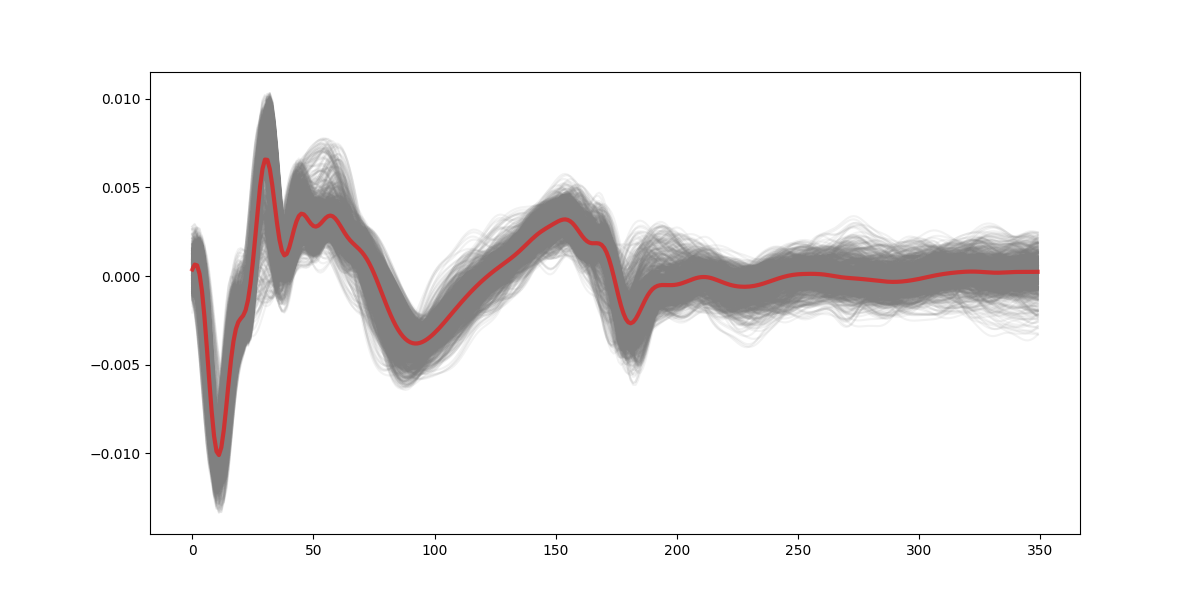

In [49]:
# Process SCG
scg_dict = process_SCG(rest_2['scg_DV'], 
                        rest_2['pcg_DV'], 
                        ecg_dict, 
                        ensembleSize=ensemble_length, 
                        useTemplateSQI=True,
                        beat_len=beat_length, 
                        Fs=FS_RESAMPLE, 
                        verbose=True)

plt.figure(figsize=(12, 6))
_=plt.plot(scg_dict['scg_beats'], color='gray', alpha=0.1)
_=plt.plot(np.mean(scg_dict['scg_beats'], axis=1), color='red', alpha=0.6, lw=3)

Engine started...
Using beats 1 to 30 for training
Was instructed to find 5. However only 4 were tracked due to non-alternating clusters
Training GMM
Done Training GMM
Using beats 1 to 50 for training
Training GMM
Done Training GMM
Least deviation ao_loc=1
Least deviation ac_loc=3


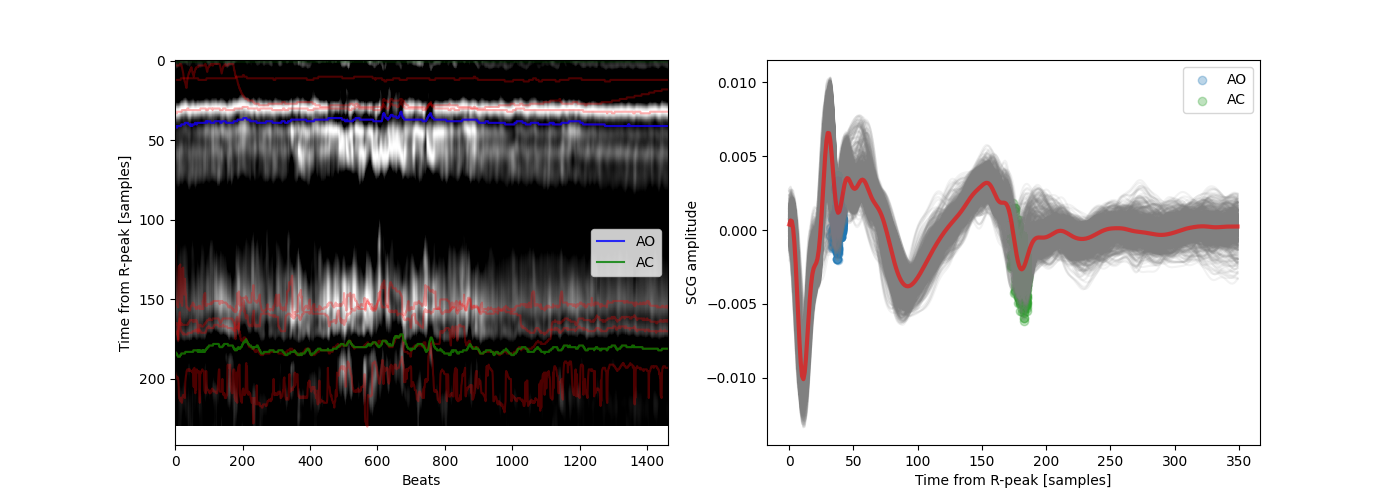

In [51]:
scg_fid_dict = extract_SCG_fiducials(scg_dict, 
                                    num_features_ao=4, 
                                    num_features_ac=3, 
                                    ema_factor=1.0, 
                                    verbose=True, 
                                    method = 'GMM') # choose between 'GMM', 'Template', or 'Jon'

ao_locs, ac_locs, flagged_ao, flagged_ac = np.squeeze(scg_fid_dict['ao_locs']), np.squeeze(scg_fid_dict['ac_locs']), scg_fid_dict['flagged_ao'], scg_fid_dict['flagged_ac']
scg_beats_used = scg_fid_dict['beats_used']
# Update these as they may have been reduced to find possible candidates
num_feats_ao, num_feats_ac = np.shape(scg_fid_dict['ao_cands'])[0], np.shape(scg_fid_dict['ac_cands'])[0]

# Plot results of fiducial tracking
scg_beats = scg_dict['scg_beats'].copy()

print(f"Least deviation ao_loc={np.argmin(np.nanstd(scg_fid_dict['ao_cands'], axis=1))}")
if num_feats_ac > 1:
    max_idx = np.nanmax(scg_fid_dict['ac_cands'][-1].T)
    print(f"Least deviation ac_loc={np.argmin(np.nanstd(scg_fid_dict['ac_cands'], axis=1))}")
else:
    max_idx = np.nanmax(scg_fid_dict['ac_cands'])
    print(f"Least deviation ac_loc={np.argmin(np.nanstd(scg_fid_dict['ac_cands']))}")
scg_beats = np.ceil(255 * (scg_beats / scg_beats.max(axis=0)))

f, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].imshow(scg_beats[:int(max_idx),:], cmap='gray',vmin = 0, vmax = 255, aspect='auto')
ax[0].plot(scg_fid_dict['ao_cands'].T, color='red', alpha=0.3)
ax[0].plot(scg_fid_dict['ac_cands'].T, color='red', alpha=0.3)
ax[0].plot(ao_locs.T, color='blue', alpha=0.8, label = 'AO')
ax[0].plot(ac_locs.T, color='g', alpha=0.8, label = 'AC')
ax[0].plot(scg_fid_dict['s1_loc']*np.ones(len(scg_fid_dict['ao_locs'])), color='green', lw=3, alpha=0.2)
ax[0].set_ylabel('Time from R-peak [samples]')
ax[0].set_xlabel('Beats')
ax[0].legend()

ao_amp = [scg_dict['scg_beats'][ao_loc_i, scg_beat_idx][0] for ao_loc_i, scg_beat_idx in zip(scg_fid_dict['ao_locs'].astype(int), scg_fid_dict['flagged_ao'])]
ac_amp = [scg_dict['scg_beats'][ac_loc_i, scg_beat_idx][0] for ac_loc_i, scg_beat_idx in zip(scg_fid_dict['ac_locs'].astype(int), scg_fid_dict['flagged_ac'])]
ax[1].plot(scg_dict['scg_beats'], color='gray', alpha=0.1)
ax[1].plot(np.mean(scg_dict['scg_beats'], axis=1), color='red', alpha=0.6, lw=3)
ax[1].scatter(scg_fid_dict['ao_locs'], ao_amp, alpha = 0.3, color = 'tab:blue', label = 'AO')
ax[1].scatter(scg_fid_dict['ac_locs'], ac_amp, alpha = 0.3, color = 'tab:green', label = 'AC')
ax[1].set_xlabel('Time from R-peak [samples]')
ax[1].set_ylabel('SCG amplitude')
ax[1].legend()


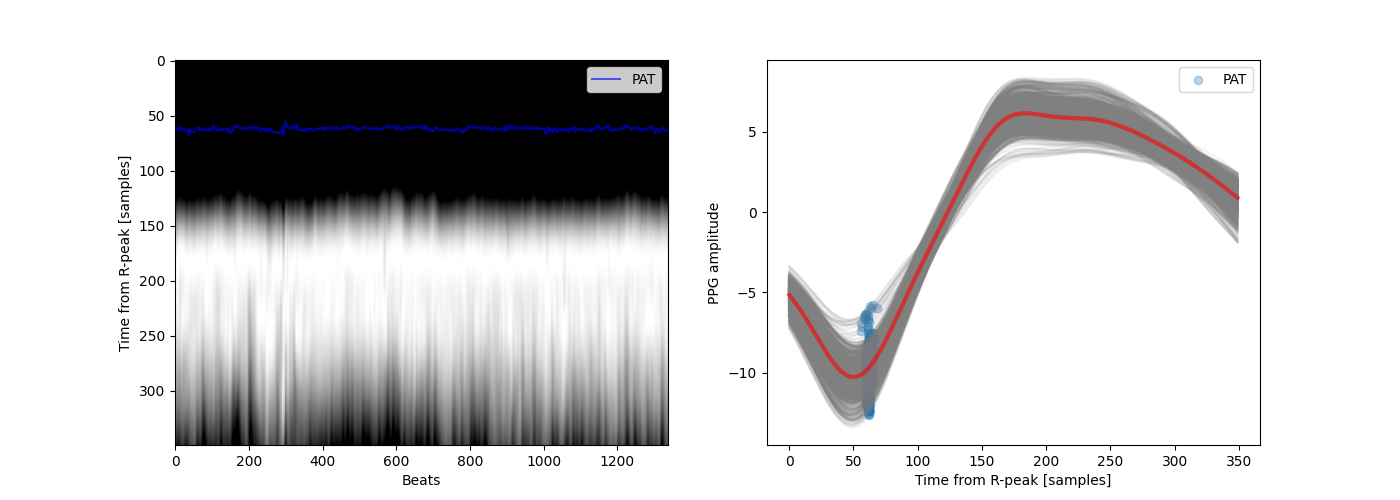

In [52]:
ppg_fid_dict = extract_PPG_fiducial(ppg_dict, memory=30, smooth=10, max_dist_foot=max_dist_foot)

ppg_beats = ppg_dict['ppg_beats'].copy()
ppg_beats = np.ceil(255 * (ppg_beats / ppg_beats.max(axis=0)))

f, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].imshow(ppg_beats, cmap='gray',vmin = 0, vmax = 255, aspect='auto')
ax[0].plot(ppg_fid_dict['pulse_locs'], color='blue', alpha=0.6, label = 'PAT')
ax[0].set_ylabel('Time from R-peak [samples]')
ax[0].set_xlabel('Beats')
ax[0].legend()


ppg_pat_amp = [ppg_dict['ppg_beats'][pat_loc_i, i] for i, pat_loc_i in  enumerate(ppg_fid_dict['pulse_locs'].astype(int))]
ax[1].plot(ppg_dict['ppg_beats'], color='gray', alpha=0.1)
ax[1].plot(np.mean(ppg_dict['ppg_beats'], axis=1), color='red', alpha=0.6, lw=3)
ax[1].scatter(ppg_fid_dict['pulse_locs'], ppg_pat_amp, alpha = 0.3, color = 'tab:blue', label = 'PAT')
ax[1].set_xlabel('Time from R-peak [samples]')
ax[1].set_ylabel('PPG amplitude')
ax[1].legend()

In [53]:
feat_df = pd.DataFrame()

In [54]:
t_feats = ecg_dict['t_beats']
feat_df['time'] = t_feats

In [55]:
feat_df['hr'] = ecg_dict['hr']

In [56]:
# Prerequisite check to see if greater than 5 minutes of data is present (necessary to compute all HRV features)
if (feat_df['time'].values[-1] - feat_df['time'].values[0]) < 5*60:
    print('Not enough data for HRV analysis')
    # Frequency-domain
    feat_df['hrv_lf'], feat_df['hrv_hf'], feat_df['hrv_lf'] = np.nan, np.nan, np.nan
    # Time-domain
    feat_df['hrv_rmssd'], feat_df['hrv_sd'], feat_df['hrv_sdsd'], feat_df['hrv_sdnn'] = np.nan, np.nan, np.nan, np.nan
# If there is enough data, compute HRV features
# else:
#   # Frequency-domain

#   # Time-domain


In [57]:
feat_PEP = np.squeeze((scg_fid_dict['ao_locs'][scg_fid_dict['flagged_ao']])*1000/FS_RESAMPLE)
ao_times = np.intersect1d(scg_fid_dict['t_ao'], feat_df.time.values)
# Add PEP values to df
for i, ao_time in enumerate(ao_times):
    feat_df.loc[feat_df.time == ao_time, 'pep'] = feat_PEP[i]

# Get beats with defined AO and AC points
ac_times = np.intersect1d(scg_fid_dict['t_ac'], feat_df.time.values)
_, ao_ind, ac_ind = np.intersect1d(ao_times, ac_times, return_indices=True)
pep_lvet_times = ao_times[ao_ind]
feat_PEP_LVET = np.squeeze((ao_locs[ao_ind])*1000/FS_RESAMPLE) / np.squeeze((ac_locs[ac_ind])*1000/FS_RESAMPLE)
# Add PEP/LVET values to df
for i, pep_lvet_time in enumerate(pep_lvet_times):
    feat_df.loc[feat_df.time == pep_lvet_time, 'pep_lvet'] = feat_PEP_LVET[i]
    
feat_LVET = np.squeeze((ac_locs[ac_ind])*1000/FS_RESAMPLE) - np.squeeze((ao_locs[ao_ind])*1000/FS_RESAMPLE)
# Add LVET values to df
for i, ac_time in enumerate(pep_lvet_times):
    feat_df.loc[feat_df.time == ac_time, 'lvet'] = feat_LVET[i]

In [58]:
ppg_amp_ac = ppg_dict['ppg_amp_ac']
ppg_amp_ac_dc = ppg_dict['ppg_amp'] # AC amplitude normalized by DC (in case of changes in contact pressure)
t_ppg_amp = ppg_dict['t_ppg_amp']
# Add PPG amplitude values to df
for i, ppg_amp_time in enumerate(t_ppg_amp):
    feat_df.loc[feat_df.time == ppg_amp_time, 'ppg_amp_ac'] = ppg_amp_ac[i]
    feat_df.loc[feat_df.time == ppg_amp_time, 'ppg_amp'] = ppg_amp_ac_dc[i]

In [59]:
feat_PAT = ppg_fid_dict['pulse_locs']
t_pat = ppg_fid_dict['t_pulse']
# Add PAT values to df
for i, pat_time in enumerate(t_pat):
    feat_df.loc[feat_df.time == pat_time, 'pat'] = feat_PAT[i]

# Find overlapping beats with PAT and PEP values for PTT
_, pat_ind, pep_ind = np.intersect1d(t_pat, ao_times, return_indices=True)
pat_for_ptt = feat_PAT[pat_ind]
pep_for_ptt = feat_PEP[pep_ind]
feat_PTT = pat_for_ptt - pep_for_ptt
t_ptt = t_pat[pat_ind]
# Add PTT values to df
for i, ptt_time in enumerate(t_ptt):
    feat_df.loc[feat_df.time == ptt_time, 'ptt'] = feat_PTT[i]

In [61]:
feat_df

,time,hr,pep,pep_lvet,lvet,ppg_amp_ac,ppg_amp,pat,ptt
0,9789.736,59.642147,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9790.742,59.523810,82.0,0.222826,286.0,NaN,NaN,NaN,NaN
2,9791.750,60.240964,82.0,0.224044,284.0,NaN,NaN,NaN,NaN
3,9792.746,61.224490,82.0,0.222826,286.0,NaN,NaN,NaN,NaN
4,9793.726,59.642147,82.0,0.222826,286.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1714,11323.030,59.880240,82.0,0.226519,280.0,NaN,NaN,NaN,NaN
1715,11324.032,59.760956,82.0,0.226519,280.0,NaN,NaN,NaN,NaN
1716,11325.036,59.523810,82.0,0.226519,280.0,NaN,NaN,NaN,NaN
1717,11326.044,58.365759,82.0,0.226519,280.0,NaN,NaN,NaN,NaN


Text(0.5, 0, 'Time (s)')

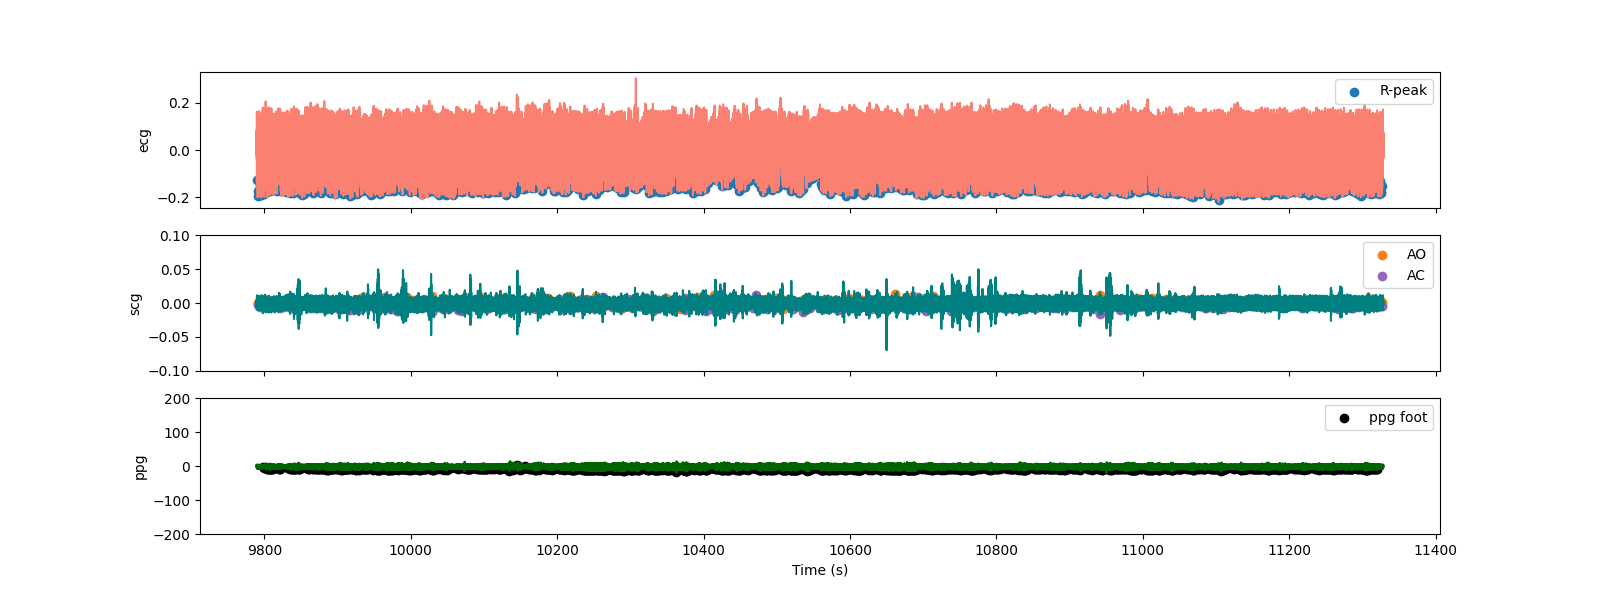

In [64]:
f, ax = plt.subplots(3, 1, figsize = (16, 6), sharex = True)
patch_filt_dict = rest_2
# Plot r-peak (ecg) features
r_peak_idx = [np.argmin(np.abs(patch_filt_dict['time'] - rpeak_i)) for rpeak_i in feat_df['time']]
ax[0].plot(patch_filt_dict['time'], patch_filt_dict['ecg'], color='salmon')
ax[0].scatter(feat_df['time'], patch_filt_dict['ecg'][r_peak_idx], color = 'tab:blue', label = 'R-peak')
ax[0].legend()
ax[0].set_ylabel('ecg')

# Plot ao (scg) features
ao_loc = feat_df['time'] + feat_df['pep']/1000
ao_idx = [np.argmin(np.abs(patch_filt_dict['time'] - ao_loc_i)) for ao_loc_i in ao_loc]
ax[1].plot(patch_filt_dict['time'], patch_filt_dict['scg_DV'], color='teal')
ax[1].scatter(feat_df['time'] + feat_df['pep']/1000, patch_filt_dict['scg_DV'][ao_idx], color = 'tab:orange', label = 'AO')


# Plot ac (scg) features
ac_loc = feat_df['time'] + (feat_df['lvet'] +  feat_df['pep'])/1000
ac_idx = [np.argmin(np.abs(patch_filt_dict['time'] - ac_loc_i)) for ac_loc_i in (ac_loc)]
ax[1].scatter(ac_loc, patch_filt_dict['scg_DV'][ac_idx], color = 'tab:purple', label = 'AC')
ax[1].set_ylim([-0.1, 0.1])
ax[1].legend()
ax[1].set_ylabel('scg')

# Plot pat (ppg) features
pat_loc = feat_df['time'] + feat_df['pat']/1000
pat_idx = [np.argmin(np.abs(patch_filt_dict['time'] - pat_loc_i)) for pat_loc_i in (pat_loc)]
ax[2].plot(patch_filt_dict['time'], patch_filt_dict[ppg_wavelen+ppg_arr], color='darkgreen')
ax[2].scatter(pat_loc, patch_filt_dict[ppg_wavelen+ppg_arr][pat_idx], color = 'k', label = 'ppg foot')
ax[2].set_ylim([-200, 200])
ax[2].legend()
ax[2].set_ylabel('ppg')
ax[2].set_xlabel('Time (s)')


Text(0.5, 0, 'Time (s)')

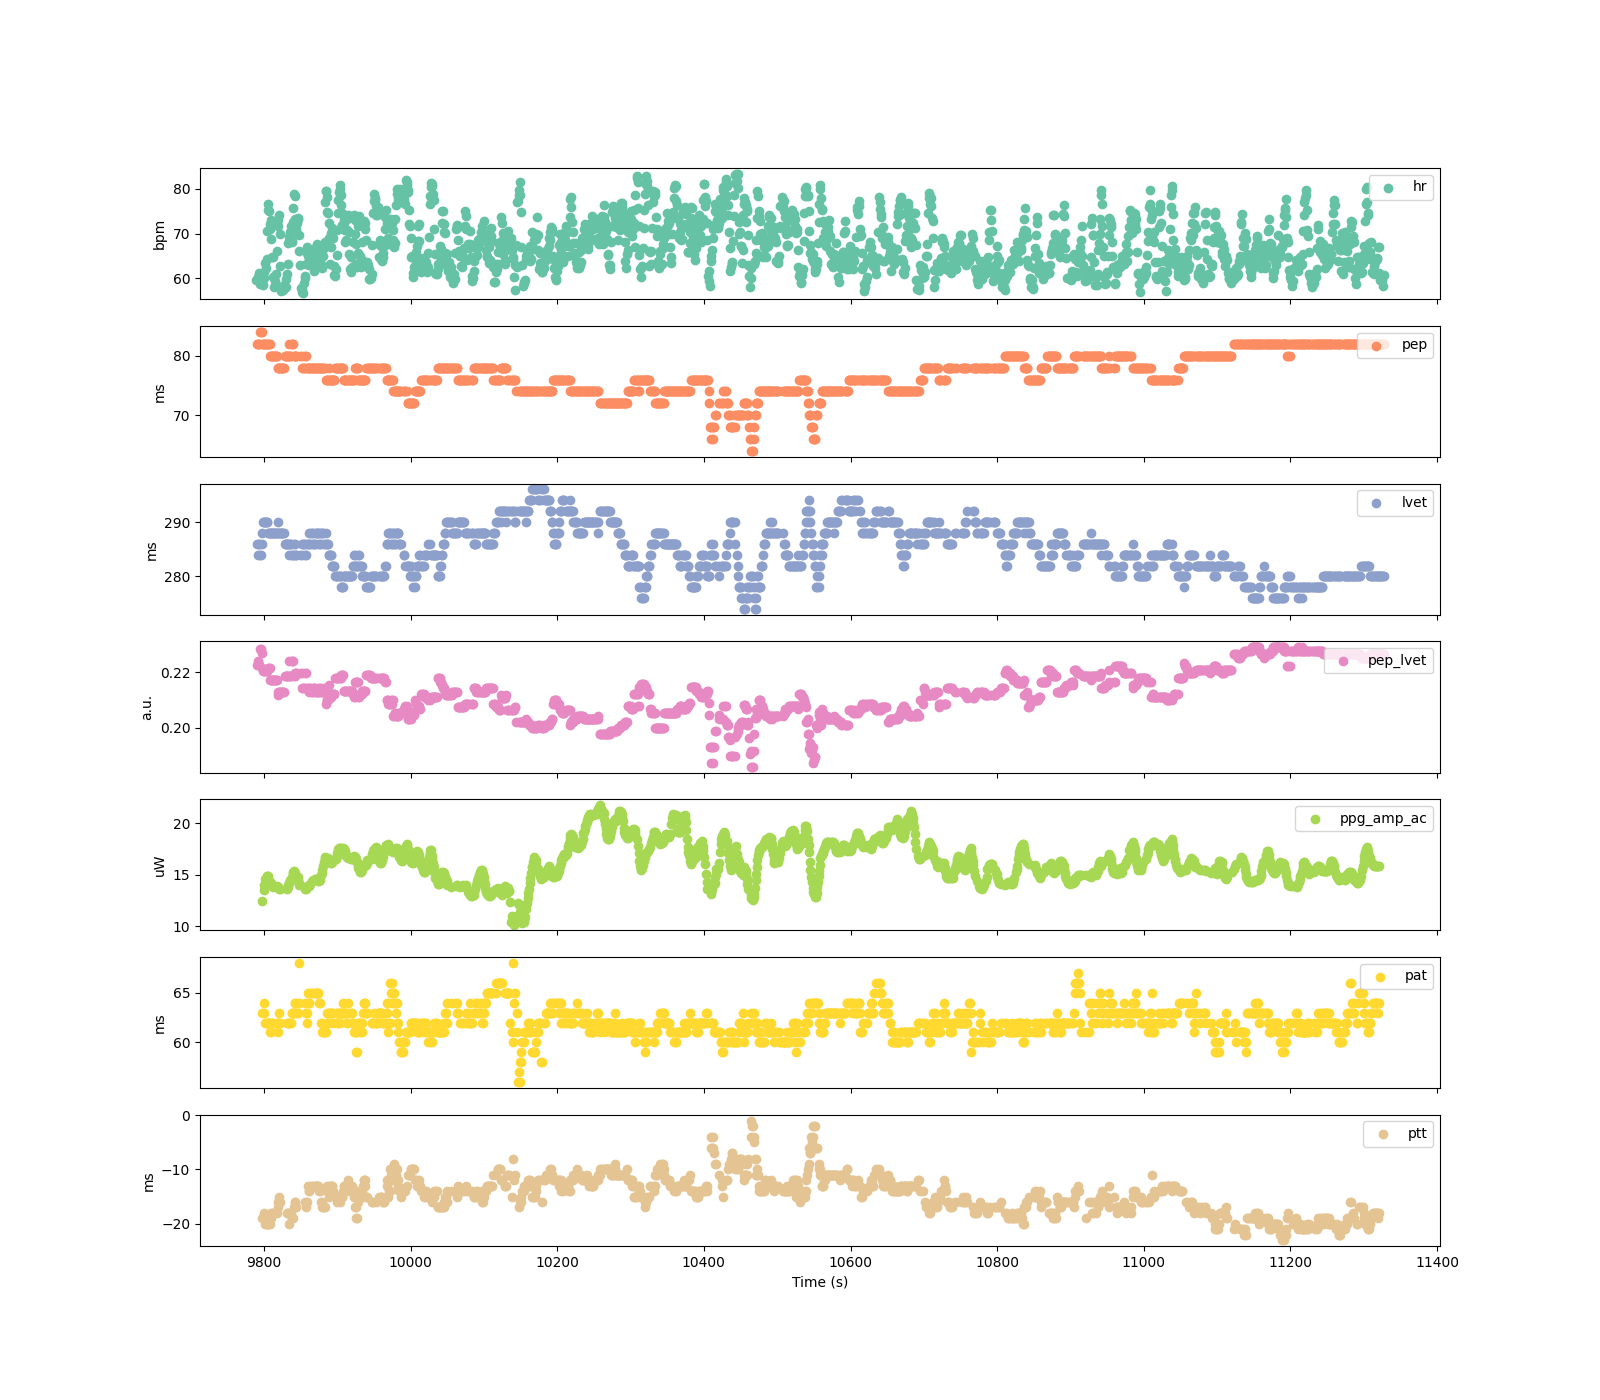

In [65]:
feats_to_plot = ['hr', 'pep', 'lvet', 'pep_lvet', 'ppg_amp_ac', 'pat', 'ptt']
feat_units = ['bpm', 'ms', 'ms', 'a.u.', 'uW', 'ms', 'ms']
colors = sns.color_palette(palette='Set2', n_colors=len(feats_to_plot))
fig, axs = plt.subplots(len(feats_to_plot), 1, sharex=True, figsize=(16,14))
for ax, feat, unit, col in zip(axs, feats_to_plot, feat_units, colors):
    ax.scatter(feat_df.time, feat_df.loc[:,feat], label=feat, color=col)
    ax.set_ylabel(unit)
    ax.legend(loc='upper right')
plt.xlabel('Time (s)')

In [66]:
feat_df.keys()

Index(['time', 'hr', 'pep', 'pep_lvet', 'lvet', 'ppg_amp_ac', 'ppg_amp', 'pat',
       'ptt'],
      dtype='object')

In [ ]:
feat_df.to_csv(outputdir+'output_features.csv', index = False)